In [2]:
__author__ = "Niraj Jayant"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)


## Overview

This will be the data exploration for 

## Set-up

In [1]:
import pandas as pd
import os
from IPython.display import display, HTML

In [2]:
WINE_SRC_FILENAME = os.path.join(
    "data", "wine-reviews", "winemag-data-130k-v2.csv")

In [93]:
df = pd.read_csv(WINE_SRC_FILENAME)
display(df.head(5))
print(df.shape)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


(129971, 14)


In [6]:
df.taster_name.describe()


count         103727
unique            19
top       Roger Voss
freq           25514
Name: taster_name, dtype: object

In [7]:
df.taster_name.value_counts().median()
df.description.apply(lambda x: len(x.split())).describe()

count    129971.000000
mean         40.379615
std          11.111982
min           3.000000
25%          33.000000
50%          39.000000
75%          47.000000
max         135.000000
Name: description, dtype: float64

In [8]:
df.points.describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

We can see from the data that we have about 19 tasters with about 5459 mean, 4177 median tastings. One possibility here is to do recommendations for these different tasters. Another option is to group wines based on descriptions and not necessarily grape. Then, when a user searches for a grape we return back one with the best score/price?

From: https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Introduction%20to%20Topic%20Modeling.ipynb
try seeing what LDA does for us

In [8]:
# data cleansing first, lets just focus on description
import re

# Remove punctuation
df['cleansed'] = df['description'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['cleansed'] = df['cleansed'].map(lambda x: x.lower())

df['cleansed'].head()

0    aromas include tropical fruit broom brimstone ...
1    this is ripe and fruity a wine that is smooth ...
2    tart and snappy the flavors of lime flesh and ...
3    pineapple rind lemon pith and orange blossom s...
4    much like the regular bottling from 2012 this ...
Name: cleansed, dtype: object

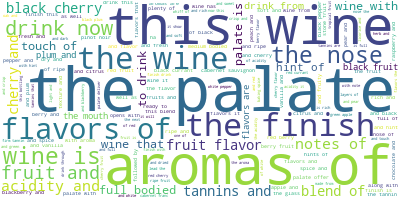

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['cleansed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

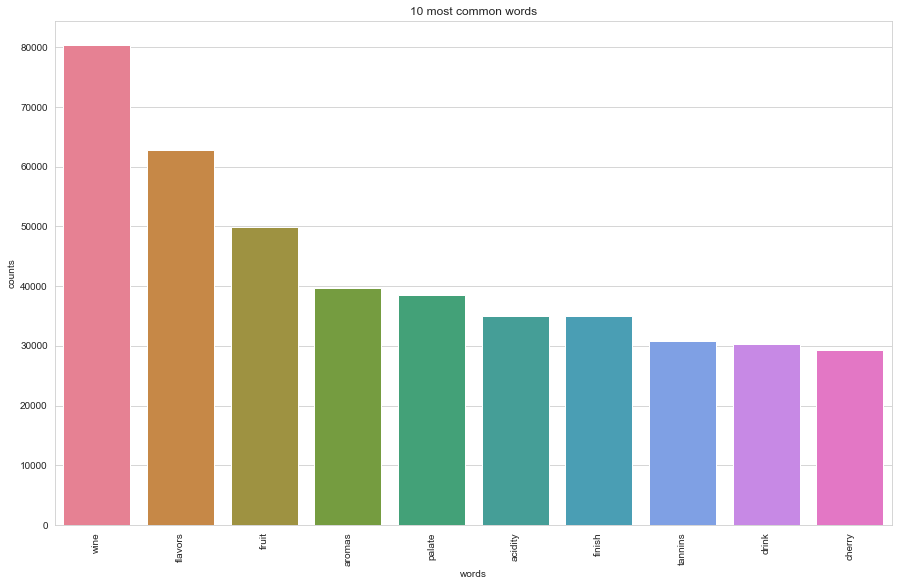

In [10]:

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['cleansed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [11]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
wine flavors acidity apple crisp citrus fruit fresh lemon dry

Topic #1:
wine fruit drink tannins acidity ripe fruits black rich red

Topic #2:
flavors wine cabernet cherry oak fruit blend tannins black sauvignon

Topic #3:
palate aromas cherry nose black offers tannins fruit red spice

Topic #4:
flavors aromas finish palate fruit berry plum notes cherry oak


In [12]:
from transformers import BertTokenizer

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [14]:
tokenizer.tokenize("Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.")

['A',
 '##roma',
 '##s',
 'include',
 'tropical',
 'fruit',
 ',',
 'br',
 '##oom',
 ',',
 'br',
 '##ims',
 '##tone',
 'and',
 'dried',
 'herb',
 '.',
 'The',
 'p',
 '##ala',
 '##te',
 'isn',
 "'",
 't',
 'overly',
 'expressive',
 ',',
 'offering',
 'un',
 '##rip',
 '##ened',
 'apple',
 ',',
 'c',
 '##itrus',
 'and',
 'dried',
 'sage',
 'alongside',
 'br',
 '##isk',
 'acid',
 '##ity',
 '.']

In [10]:
df.variety[:5]

0       White Blend
1    Portuguese Red
2        Pinot Gris
3          Riesling
4        Pinot Noir
Name: variety, dtype: object

In [29]:
counts = df.variety.value_counts()
df.variety.describe()
print(counts[counts < 50].index)

Index(['Weissburgunder', 'Müller-Thurgau', 'Pinot Meunier', 'Malvasia',
       'Assyrtico', 'Prugnolo Gentile', 'Cabernet Sauvignon-Carmenère',
       'Graciano', 'Pedro Ximénez', 'Cinsault',
       ...
       'Garnacha-Cariñena', 'Francisa', 'Sauvignon Blanc-Sauvignon Gris',
       'Bobal-Cabernet Sauvignon', 'Pinot Blanc-Viognier', 'Muscadel',
       'St. Vincent', 'Tempranillo-Tannat', 'Franconia', 'Tinto Velasco'],
      dtype='object', length=576)


In [52]:
# Remove all entries that have less than 100 reviews
df = df[df.groupby('variety')['variety'].transform('count').ge(100)]
print(df.shape)

# Remove blends
df = df[~df.variety.str.contains("Blend")]

# Remove More blends manually
filters = ['Blend', 'Cabernet Sauvignon-Merlot', 'Cabernet Sauvignon-Syrah', 'Meritage', 'G-S-M']
for filtered_variety in filters:
    df = df[~df.variety.str.contains(filtered_variety)]

print(df.shape)

(96535, 14)
(96433, 14)


In [53]:
# used to determine that Sauvignon is Sauvignon Blanc
df_Sauvignon = df.loc[df['variety'] == 'Sauvignon']
print(df_Sauvignon.shape)
with pd.option_context("display.max_rows", 1000):
    print(df_Sauvignon.description)

(0, 14)
Series([], Name: description, dtype: object)


In [54]:
# now print varieties
with pd.option_context("display.max_rows", 1000):
    print(df.variety.value_counts())


Pinot Noir                       13453
Chardonnay                       11753
Cabernet Sauvignon                9472
Sauvignon Blanc                   5283
Riesling                          5189
Syrah                             4978
Rosé                              3667
Pinot Grigio                      3103
Merlot                            3102
Zinfandel                         2936
Nebbiolo                          2804
Sangiovese                        2707
Malbec                            2652
Portuguese Red                    2466
Tempranillo                       2076
Cabernet Franc                    1353
Grüner Veltliner                  1345
Gamay                             1257
Portuguese White                  1159
Gewürztraminer                    1012
Viognier                           996
Grenache                           977
Prosecco                           945
Petite Sirah                       770
Sangiovese Grosso                  751
Barbera                  

In [57]:
# code taken from here: https://github.com/RoaldSchuring/wine_recommender/blob/master/creating_wine_review_embeddings.ipynb
variety_mapping = {'Shiraz': 'Syrah', 
                   'Pinot Gris': 'Pinot Grigio', 'Pinot Blanc': 'Pinot Grigio',  'Pinot Bianco' : 'Pinot Grigio', 
                   'Garnacha': 'Grenache',
                   'Alvarinho' : 'Albariño',
                    'Muscat' : 'Moscato',
                   'Glera' : 'Prosecco',
                   'Sauvignon': 'Sauvignon Blanc',
                   'Blaufränkisch': 'Gamay',
                   'Primitivo': 'Zinfandel',
                   'Pinot Nero': 'Pinot Noir',
                   'Tinta de Toro': 'Tempranillo', 'Tinto Fino': 'Tempranillo',
                    'Monastrell': 'Mourvèdre',
                   'Alvarinho': 'Albariño',
                   'Rosato': 'Rosé',
                  }

def consolidate_varieties(variety_name):
    if variety_name in variety_mapping:
        return variety_mapping[variety_name]
    else:
        return variety_name

df['variety'] = df['variety'].apply(consolidate_varieties)
print(df.shape)
with pd.option_context("display.max_rows", 1000):
    print(df.variety.value_counts().to_latex(index=True))

(96433, 14)
\begin{tabular}{lr}
\toprule
{} &  variety \\
\midrule
Pinot Noir                    &    13453 \\
Chardonnay                    &    11753 \\
Cabernet Sauvignon            &     9472 \\
Sauvignon Blanc               &     5283 \\
Riesling                      &     5189 \\
Syrah                         &     4978 \\
Rosé                          &     3667 \\
Pinot Grigio                  &     3103 \\
Merlot                        &     3102 \\
Zinfandel                     &     2936 \\
Nebbiolo                      &     2804 \\
Sangiovese                    &     2707 \\
Malbec                        &     2652 \\
Portuguese Red                &     2466 \\
Tempranillo                   &     2076 \\
Cabernet Franc                &     1353 \\
Grüner Veltliner              &     1345 \\
Gamay                         &     1257 \\
Portuguese White              &     1159 \\
Gewürztraminer                &     1012 \\
Viognier                      &      996 \\
Grenache 

In [66]:
# Imports
import os
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from collections import Counter, OrderedDict

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [60]:
# Starting to data clean the descriptions

df_copy = df.copy() # just make a copy in case we mess things up

reviews_list = list(df_copy['description'])
reviews_list = [str(r) for r in reviews_list]
full_corpus = ' '.join(reviews_list)
sentences_tokenized = sent_tokenize(full_corpus)

print(sentences_tokenized[:5])

['Aromas include tropical fruit, broom, brimstone and dried herb.', "The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.", 'This is ripe and fruity, a wine that is smooth while still structured.', 'Firm tannins are filled out with juicy red berry fruits and freshened with acidity.', "It's  already drinkable, although it will certainly be better from 2016."]


In [64]:
stop_words = set(stopwords.words('english')) 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def normalize_text(raw_text):
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

# sentence_sample = sentences_tokenized[:10]
normalized_sentences = []
for s in sentences_tokenized:
    normalized_text = normalize_text(s)
    normalized_sentences.append(normalized_text)

In [65]:
normalized_sentences[:10]

[['aroma', 'includ', 'tropic', 'fruit', 'broom', 'brimston', 'dri', 'herb'],
 ['palat',
  'nt',
  'express',
  'offer',
  'unripen',
  'appl',
  'citrus',
  'dri',
  'sage',
  'alongsid',
  'brisk',
  'acid'],
 ['ripe', 'fruiti', 'wine', 'smooth', 'still', 'structur'],
 ['firm',
  'tannin',
  'fill',
  'juici',
  'red',
  'berri',
  'fruit',
  'freshen',
  'acid'],
 ['alreadi', 'drinkabl', 'although', 'certain', 'better', '2016'],
 ['tart', 'snappi', 'flavor', 'lime', 'flesh', 'rind', 'domin'],
 ['green', 'pineappl', 'poke', 'crisp', 'acid', 'underscor', 'flavor'],
 ['wine', 'stainlesssteel', 'ferment'],
 ['pineappl', 'rind', 'lemon', 'pith', 'orang', 'blossom', 'start', 'aroma'],
 ['palat',
  'bit',
  'opul',
  'note',
  'honeydrizzl',
  'guava',
  'mango',
  'give',
  'way',
  'slight',
  'astring',
  'semidri',
  'finish']]

In [67]:
phrases = Phrases(normalized_sentences)
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in normalized_sentences:
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]


In [69]:
full_list_words[:100]

['aroma',
 'includ',
 'tropic',
 'fruit',
 'broom',
 'brimston',
 'dri',
 'herb',
 'palat',
 'nt',
 'express',
 'offer',
 'unripen',
 'appl',
 'citrus',
 'dri',
 'sage',
 'alongsid',
 'brisk',
 'acid',
 'ripe',
 'fruiti',
 'wine',
 'smooth',
 'still',
 'structur',
 'firm',
 'tannin',
 'fill',
 'juici',
 'red',
 'berri',
 'fruit',
 'freshen',
 'acid',
 'alreadi_drinkabl',
 'although',
 'certain',
 'better_2016',
 'tart',
 'snappi',
 'flavor',
 'lime',
 'flesh_rind',
 'domin',
 'green',
 'pineappl',
 'poke',
 'crisp',
 'acid',
 'underscor',
 'flavor',
 'wine',
 'stainlesssteel_ferment',
 'pineappl',
 'rind',
 'lemon_pith',
 'orang_blossom',
 'start',
 'aroma',
 'palat',
 'bit',
 'opul',
 'note',
 'honeydrizzl',
 'guava_mango',
 'give_way',
 'slight',
 'astring',
 'semidri',
 'finish',
 'much',
 'like',
 'regular_bottl',
 '2012',
 'come_across',
 'rather',
 'rough',
 'tannic',
 'rustic',
 'earthi',
 'herbal',
 'characterist',
 'nonetheless',
 'think',
 'pleasant',
 'unfussi',
 'countri',


In [70]:
word_counts = Counter(full_list_words)
sorted_counts = OrderedDict(word_counts.most_common(5000))
counter_df = pd.DataFrame.from_dict(sorted_counts, orient='index')
# top_5000_words = counter_df.head(5000)
counter_df.to_csv('top_5000_descriptors.csv')

In [71]:
counter_df.head(100)

,0
wine,82803
flavor,70024
fruit,55229
aroma,40982
finish,40235
...,...
style,5008
honey,4834
deliv,4779
vineyard,4717


In [72]:
normalized_sentences = []
for sent in phrased_sentences:
    normalized_sentence = []
    for word in sent:
        normalized_sentence.append(word)
    normalized_sentences.append(normalized_sentence)

In [73]:
wine_word2vec_model = Word2Vec(normalized_sentences, size=300, min_count=5, iter=15)
print(wine_word2vec_model)

wine_word2vec_model.save('wine_word2vec_model.bin')

Word2Vec(vocab=16468, size=300, alpha=0.025)


In [74]:
wine_word2vec_model.wv.most_similar(positive='peach', topn=10)

[('white_peach', 0.7778827548027039),
 ('stone_fruit', 0.7103622555732727),
 ('yellow_peach', 0.709530234336853),
 ('peach_nectarin', 0.7082720398902893),
 ('whitepeach', 0.7004714608192444),
 ('stonefruit', 0.6175204515457153),
 ('peach_nectar', 0.6102508902549744),
 ('kiwi', 0.6089266538619995),
 ('honeydew', 0.5909467935562134),
 ('quinc', 0.5789718627929688)]

In [75]:
df_year = pd.read_csv(WINE_SRC_FILENAME)


In [76]:
years = df_year.pop('title')

In [91]:
print(years.head(10).to_latex(index=True))

\begin{tabular}{ll}
\toprule
{} &                                              title \\
\midrule
0 &                  Nicosia 2013 Vulkà Bianco  (Etna) \\
1 &      Quinta dos Avidagos 2011 Avidagos Red (Douro) \\
2 &      Rainstorm 2013 Pinot Gris (Willamette Valley) \\
3 &  St. Julian 2013 Reserve Late Harvest Riesling ... \\
4 &  Sweet Cheeks 2012 Vintner's Reserve Wild Child... \\
5 &  Tandem 2011 Ars In Vitro Tempranillo-Merlot (N... \\
6 &   Terre di Giurfo 2013 Belsito Frappato (Vittoria) \\
7 &              Trimbach 2012 Gewurztraminer (Alsace) \\
8 &  Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe... \\
9 &  Jean-Baptiste Adam 2012 Les Natures Pinot Gris... \\
\bottomrule
\end{tabular}



In [87]:
# Code to extract the year from the title
print(years.str)
years_reg = years.str.extract(r'([0-9]{4})')
print(years_reg)

           0
0       2013
1       2011
2       2013
3       2013
4       2012
...      ...
129966  2013
129967  2004
129968  2013
129969  2012
129970  2012

[129971 rows x 1 columns]
